In [1]:
import pandas
import time

from lib.policy_guided_explorer import Explorer
from lib.models.generic_v0.model import mappable_params

from lib.models.aft20barzur import BitcoinSM as AFT20BarZur
from lib.models.fc16sapirshtein import BitcoinSM as FC16Sapirshtein

from lib.models.generic_v1 import protocols as g1
from lib.models.generic_v1.model import SingleAgent as G1Model

from lib.models.generic_v0.bitcoin import Bitcoin as G0Bitcoin
from lib.models.generic_v0.model import SelfishMining as G0Model

In [2]:
network = mappable_params

models = []
implicit_mdps = []


def add_model(*, implicit_mdp, **model):
    models.append(model)
    implicit_mdps.append(implicit_mdp)


# related work baseline

add_model(
    scenario="reference",
    model="fc16sapirshtein",
    force_consider_own=True,
    merge_isomorphic=True,
    truncate_common_chain=True,
    collect_garbage=True,
    reward_common_chain=True,
    protocol="bitcoin",
    implicit_mdp=FC16Sapirshtein(**network, maximum_fork_length=999999),
)

add_model(
    scenario="reference-v0",
    model="generic_0",
    force_consider_own=True,
    merge_isomorphic=True,
    truncate_common_chain=True,
    collect_garbage=True,
    reward_common_chain=True,
    protocol="bitcoin",
    implicit_mdp=G0Model(
        G0Bitcoin(),
        **network,
        maximum_size=999999,
        force_consider_own=True,
        merge_isomorphic=True,
    ),
)

# our baseline: garbage collection + common chain truncation
# we want to compare to:
# - no common chain truncation (all infinite)
# - no garbage collection (infinite for protocols that allow stale blocks)
# - plus force-consider-own
# - plus merge-isomorphic
# - plus both


def add_scenario(
    scenario,
    *,
    force_consider_own=False,
    merge_isomorphic=False,
):
    def f(protocol_s, protocol_C, **protocol_args):
        model_args = dict(
            force_consider_own=force_consider_own,
            merge_isomorphic=merge_isomorphic,
            truncate_common_chain=True,
            collect_garbage=True,
            reward_common_chain=False,
        )
        add_model(
            scenario=scenario,
            model="generic_1",
            protocol=protocol_s,
            **model_args,
            implicit_mdp=G1Model(
                protocol_C,
                **protocol_args,
                **network,
                **model_args,
            ),
        )

    f("bitcoin", g1.Bitcoin)
    f("ethereum_3", g1.Ethereum, h=3)
    f("byzantium_3", g1.Byzantium, h=3)
    f("ghostdag_3", g1.Ghostdag, k=3)
    f("parallel_3", g1.Parallel, k=3)


add_scenario("baseline")
add_scenario("w/ force consider", force_consider_own=True)
add_scenario("w/ normalization", merge_isomorphic=True)
add_scenario("w/ both", force_consider_own=True, merge_isomorphic=True)

models = pandas.DataFrame(models)
models

,scenario,model,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,protocol
0,reference,fc16sapirshtein,True,True,True,True,True,bitcoin
1,reference-v0,generic_0,True,True,True,True,True,bitcoin
2,baseline,generic_1,False,False,True,True,False,bitcoin
3,baseline,generic_1,False,False,True,True,False,ethereum_3
4,baseline,generic_1,False,False,True,True,False,byzantium_3
5,baseline,generic_1,False,False,True,True,False,ghostdag_3
6,baseline,generic_1,False,False,True,True,False,parallel_3
7,w/ force consider,generic_1,True,False,True,True,False,bitcoin
8,w/ force consider,generic_1,True,False,True,True,False,ethereum_3
9,w/ force consider,generic_1,True,False,True,True,False,byzantium_3


In [3]:
!mkdir -p 4-generated-mdps

In [4]:
from IPython.display import display, clear_output
import gc
import psutil
import pickle
import gzip

max_size = 100000
# max_size = 10000
aborts = []
size_log = []


def get_rss():
    gc.collect()
    return psutil.Process().memory_info().rss / 1024**3  # GiB


for idx, row in models.iterrows():
    m = implicit_mdps[idx]
    explorer = Explorer(m, m.honest)
    start_time = time.monotonic()
    depth = 0

    def log():
        info = row.to_dict() | dict(
            depth=depth,
            size=explorer.n_states,
            time_spent=time.monotonic() - start_time,
            rss=get_rss(),
        )
        mdp_key = format(abs(hash(frozenset(info.items()))), "08x")[0:8]
        size_log.append(row.to_dict() | info | dict(mdp=mdp_key))
        with gzip.open(f"4-generated-mdps/mdp-{mdp_key}.pkl.gz", "wb") as f:
            pickle.dump(explorer.mdp(), f)

        # report to stdout
        d = size_log[-1]
        print(
            "\r"
            + "\t".join(
                [
                    f"{k}: {d[k]}"
                    for k in [
                        "scenario",
                        "protocol",
                        "depth",
                        "size",
                        "time_spent",
                        "rss",
                    ]
                ]
            ),
            end="",
        )

    try:
        explorer.explore_along_policy(max_states=max_size)
    except RuntimeError as e:
        if e.args == ("state size limit exceeded",):
            gc.collect()
            aborts.append(
                row.to_dict()
                | dict(
                    reason="state size limit exceeded",
                    depth=0,
                    time_spent=time.monotonic() - start_time,
                    rss=get_rss(),
                )
            )
            continue
        else:
            raise e

    log()

    while True:
        # increase depth by one
        try:
            explorer.explore_aside_policy(max_states=max_size)
            explorer.explore_along_policy(max_states=max_size)
        except RuntimeError as e:
            if e.args == ("state size limit exceeded",):
                aborts.append(
                    row.to_dict()
                    | dict(
                        reason="state size limit exceeded",
                        depth=depth + 1,
                        time_spent=time.monotonic() - start_time,
                        rss=get_rss(),
                    )
                )
                break
            else:
                raise e

        depth += 1
        log()


size_log = pandas.DataFrame(size_log)
aborts = pandas.DataFrame(aborts)

size_log.to_pickle("4-generated-mdps/success.pkl.gz")
aborts.to_pickle("4-generated-mdps/fail.pkl.gz")

scenario: reference	protocol: bitcoin	depth: 1	size: 7	time_spent: 0.03902010100136977	rss: 0.10803604125976562

scenario: reference	protocol: bitcoin	depth: 7	size: 85	time_spent: 0.21978045900323195	rss: 0.10828018188476562

scenario: reference	protocol: bitcoin	depth: 9	size: 131	time_spent: 0.28482348500256194	rss: 0.10864639282226562

scenario: reference	protocol: bitcoin	depth: 13	size: 253	time_spent: 0.4359795220007072	rss: 0.10925674438476562

scenario: reference	protocol: bitcoin	depth: 15	size: 329	time_spent: 0.5211747089997516	rss: 0.10962295532226562

scenario: reference	protocol: bitcoin	depth: 18	size: 462	time_spent: 0.6649437750020297	rss: 0.11059951782226562

scenario: reference	protocol: bitcoin	depth: 20	size: 563	time_spent: 0.7767877630030853	rss: 0.11096572875976562

scenario: reference	protocol: bitcoin	depth: 22	size: 674	time_spent: 0.8994636610004818	rss: 0.11145401000976562

scenario: reference	protocol: bitcoin	depth: 24	size: 795	time_spent: 1.0332671639989712	rss: 0.11194229125976562

scenario: reference	protocol: bitcoin	depth: 25	size: 859	time_spent: 1.106560542000807	rss: 0.11255264282226562

scenario: reference	protocol: bitcoin	depth: 27	size: 995	time_spent: 1.274479767002049	rss: 0.11328506469726562

scenario: reference	protocol: bitcoin	depth: 28	size: 1067	time_spent: 1.3568563420049031	rss: 0.11352920532226562

scenario: reference	protocol: bitcoin	depth: 30	size: 1218	time_spent: 1.5325658150031813	rss: 0.11413955688476562

scenario: reference	protocol: bitcoin	depth: 31	size: 1297	time_spent: 1.627645182001288	rss: 0.11450576782226562

scenario: reference	protocol: bitcoin	depth: 33	size: 1463	time_spent: 1.8322216610031319	rss: 0.11523818969726562

scenario: reference	protocol: bitcoin	depth: 34	size: 1550	time_spent: 1.9424106709993794	rss: 0.1169891357421875

scenario: reference	protocol: bitcoin	depth: 35	size: 1639	time_spent: 2.057592356002715	rss: 0.1174774169921875

scenario: reference	protocol: bitcoin	depth: 36	size: 1731	time_spent: 2.1779216280046967	rss: 0.11765670776367188

scenario: reference	protocol: bitcoin	depth: 37	size: 1825	time_spent: 2.3037474299999303	rss: 0.118072509765625

scenario: reference	protocol: bitcoin	depth: 38	size: 1922	time_spent: 2.43377633500495	rss: 0.11828994750976562

scenario: reference	protocol: bitcoin	depth: 39	size: 2021	time_spent: 2.570729413004301	rss: 0.1189727783203125

scenario: reference	protocol: bitcoin	depth: 40	size: 2123	time_spent: 2.7119749400008004	rss: 0.11973953247070312

scenario: reference	protocol: bitcoin	depth: 41	size: 2227	time_spent: 2.8592430760036223	rss: 0.11995697021484375

scenario: reference	protocol: bitcoin	depth: 42	size: 2334	time_spent: 3.0114056330057792	rss: 0.12043380737304688

scenario: reference	protocol: bitcoin	depth: 43	size: 2443	time_spent: 3.171242742006143	rss: 0.12067413330078125

scenario: reference	protocol: bitcoin	depth: 44	size: 2555	time_spent: 3.336657302999811	rss: 0.12117385864257812

scenario: reference	protocol: bitcoin	depth: 45	size: 2669	time_spent: 3.5080612910023774	rss: 0.12168121337890625

scenario: reference	protocol: bitcoin	depth: 46	size: 2786	time_spent: 3.687407502999122	rss: 0.12195968627929688

scenario: reference	protocol: bitcoin	depth: 47	size: 2905	time_spent: 3.870771660003811	rss: 0.12225723266601562

scenario: reference	protocol: bitcoin	depth: 48	size: 3027	time_spent: 4.065952295000898	rss: 0.1225738525390625

scenario: reference	protocol: bitcoin	depth: 49	size: 3151	time_spent: 4.267761497001629	rss: 0.12017440795898438

scenario: reference	protocol: bitcoin	depth: 50	size: 3278	time_spent: 4.4781999430051656	rss: 0.120391845703125

scenario: reference	protocol: bitcoin	depth: 51	size: 3407	time_spent: 4.696037023000827	rss: 0.1207275390625

scenario: reference	protocol: bitcoin	depth: 52	size: 3539	time_spent: 4.918581701000221	rss: 0.12107086181640625

scenario: reference	protocol: bitcoin	depth: 53	size: 3673	time_spent: 5.150102145002165	rss: 0.12160873413085938

scenario: reference	protocol: bitcoin	depth: 54	size: 3810	time_spent: 5.388779858003545	rss: 0.122039794921875

scenario: reference	protocol: bitcoin	depth: 55	size: 3949	time_spent: 5.6299087240040535	rss: 0.12253189086914062

scenario: reference	protocol: bitcoin	depth: 56	size: 4091	time_spent: 5.878019360003236	rss: 0.12267303466796875

scenario: reference	protocol: bitcoin	depth: 57	size: 4235	time_spent: 6.140534493999439	rss: 0.12308120727539062

scenario: reference	protocol: bitcoin	depth: 58	size: 4382	time_spent: 6.411874860001262	rss: 0.12316131591796875

scenario: reference	protocol: bitcoin	depth: 59	size: 4531	time_spent: 6.752944953004771	rss: 0.1235504150390625

scenario: reference	protocol: bitcoin	depth: 60	size: 4683	time_spent: 7.043939736002358	rss: 0.123779296875

scenario: reference	protocol: bitcoin	depth: 61	size: 4837	time_spent: 7.388826967006025	rss: 0.12451553344726562

scenario: reference	protocol: bitcoin	depth: 62	size: 4994	time_spent: 7.761924220001674	rss: 0.12520599365234375

scenario: reference	protocol: bitcoin	depth: 63	size: 5153	time_spent: 8.161996145005105	rss: 0.12598419189453125

scenario: reference	protocol: bitcoin	depth: 64	size: 5315	time_spent: 8.573389629003941	rss: 0.1266632080078125

scenario: reference	protocol: bitcoin	depth: 65	size: 5479	time_spent: 8.995683142005873	rss: 0.12767791748046875

scenario: reference	protocol: bitcoin	depth: 66	size: 5646	time_spent: 9.42903177300468	rss: 0.1285400390625

scenario: reference	protocol: bitcoin	depth: 67	size: 5815	time_spent: 9.888138612004695	rss: 0.129302978515625

scenario: reference	protocol: bitcoin	depth: 68	size: 5987	time_spent: 10.385619650005538	rss: 0.13695526123046875

scenario: reference	protocol: bitcoin	depth: 69	size: 6161	time_spent: 10.900514026005112	rss: 0.13140869140625

scenario: reference	protocol: bitcoin	depth: 70	size: 6338	time_spent: 11.426788361000945	rss: 0.13233566284179688

scenario: reference	protocol: bitcoin	depth: 71	size: 6517	time_spent: 11.947093016002327	rss: 0.13299942016601562

scenario: reference	protocol: bitcoin	depth: 72	size: 6699	time_spent: 12.454187766001269	rss: 0.13359451293945312

scenario: reference	protocol: bitcoin	depth: 73	size: 6883	time_spent: 13.06222173700371	rss: 0.13492202758789062

scenario: reference	protocol: bitcoin	depth: 74	size: 7070	time_spent: 13.602414007000334	rss: 0.13552093505859375

scenario: reference	protocol: bitcoin	depth: 75	size: 7259	time_spent: 14.151538279002125	rss: 0.13640594482421875

scenario: reference	protocol: bitcoin	depth: 76	size: 7451	time_spent: 14.704785873000219	rss: 0.13709640502929688

scenario: reference	protocol: bitcoin	depth: 77	size: 7645	time_spent: 15.255769677001808	rss: 0.13773727416992188

scenario: reference	protocol: bitcoin	depth: 78	size: 7842	time_spent: 15.811111815004551	rss: 0.13816452026367188

scenario: reference	protocol: bitcoin	depth: 79	size: 8041	time_spent: 16.381327101000352	rss: 0.13856887817382812

scenario: reference	protocol: bitcoin	depth: 80	size: 8243	time_spent: 16.960702337004477	rss: 0.13924789428710938

scenario: reference	protocol: bitcoin	depth: 81	size: 8447	time_spent: 17.562657113005116	rss: 0.13967514038085938

scenario: reference	protocol: bitcoin	depth: 82	size: 8654	time_spent: 18.200308389001293	rss: 0.139892578125

scenario: reference	protocol: bitcoin	depth: 83	size: 8863	time_spent: 18.842903217999265	rss: 0.14010238647460938

scenario: reference	protocol: bitcoin	depth: 84	size: 9075	time_spent: 19.49373550400196	rss: 0.14105987548828125

scenario: reference	protocol: bitcoin	depth: 85	size: 9289	time_spent: 20.161134319001576	rss: 0.14129638671875

scenario: reference	protocol: bitcoin	depth: 86	size: 9506	time_spent: 20.82523858800414	rss: 0.14178466796875

scenario: reference	protocol: bitcoin	depth: 87	size: 9725	time_spent: 21.51234159299929	rss: 0.14224624633789062

scenario: reference	protocol: bitcoin	depth: 88	size: 9947	time_spent: 22.2017316019992	rss: 0.14276504516601562

scenario: reference	protocol: bitcoin	depth: 89	size: 10171	time_spent: 22.9057056580059	rss: 0.14329147338867188

scenario: reference	protocol: bitcoin	depth: 90	size: 10398	time_spent: 23.62577332300134	rss: 0.144073486328125

scenario: reference	protocol: bitcoin	depth: 91	size: 10627	time_spent: 24.35426103899954	rss: 0.14463043212890625

scenario: reference	protocol: bitcoin	depth: 92	size: 10859	time_spent: 25.102790048003953	rss: 0.1451873779296875

scenario: reference	protocol: bitcoin	depth: 93	size: 11093	time_spent: 25.8675073350023	rss: 0.14622879028320312

scenario: reference	protocol: bitcoin	depth: 94	size: 11330	time_spent: 26.650257344001147	rss: 0.15607833862304688

scenario: reference	protocol: bitcoin	depth: 95	size: 11569	time_spent: 27.513862921005057	rss: 0.1623077392578125

scenario: reference	protocol: bitcoin	depth: 96	size: 11811	time_spent: 28.423359181004344	rss: 0.16741180419921875

scenario: reference	protocol: bitcoin	depth: 97	size: 12055	time_spent: 29.361503725005605	rss: 0.16804885864257812

scenario: reference	protocol: bitcoin	depth: 98	size: 12302	time_spent: 30.34240292300092	rss: 0.1685333251953125

scenario: reference	protocol: bitcoin	depth: 99	size: 12551	time_spent: 31.251080175003153	rss: 0.16911697387695312

scenario: reference	protocol: bitcoin	depth: 100	size: 12803	time_spent: 32.133127502005664	rss: 0.16928863525390625

scenario: reference	protocol: bitcoin	depth: 101	size: 13057	time_spent: 33.05418525099958	rss: 0.169769287109375

scenario: reference	protocol: bitcoin	depth: 102	size: 13314	time_spent: 33.99704090200248	rss: 0.170623779296875

scenario: reference	protocol: bitcoin	depth: 103	size: 13573	time_spent: 34.9521168900028	rss: 0.1713104248046875

scenario: reference	protocol: bitcoin	depth: 104	size: 13835	time_spent: 35.91348602500511	rss: 0.17183303833007812

scenario: reference	protocol: bitcoin	depth: 105	size: 14099	time_spent: 36.89304474700475	rss: 0.17230606079101562

scenario: reference	protocol: bitcoin	depth: 106	size: 14366	time_spent: 37.91361715200037	rss: 0.1727752685546875

scenario: reference	protocol: bitcoin	depth: 107	size: 14635	time_spent: 38.95353692800563	rss: 0.17360305786132812

scenario: reference	protocol: bitcoin	depth: 108	size: 14907	time_spent: 39.98540555500222	rss: 0.17435455322265625

scenario: reference	protocol: bitcoin	depth: 109	size: 15181	time_spent: 41.02315147899935	rss: 0.17486572265625

scenario: reference	protocol: bitcoin	depth: 110	size: 15458	time_spent: 42.096366044002934	rss: 0.17527389526367188

scenario: reference	protocol: bitcoin	depth: 111	size: 15737	time_spent: 43.1717722060057	rss: 0.17580795288085938

scenario: reference	protocol: bitcoin	depth: 112	size: 16019	time_spent: 44.26656919800007	rss: 0.17636489868164062

scenario: reference	protocol: bitcoin	depth: 113	size: 16303	time_spent: 45.383486578000884	rss: 0.17716217041015625

scenario: reference	protocol: bitcoin	depth: 114	size: 16590	time_spent: 46.53894612099975	rss: 0.17800521850585938

scenario: reference	protocol: bitcoin	depth: 115	size: 16879	time_spent: 47.81786226800614	rss: 0.17833709716796875

scenario: reference	protocol: bitcoin	depth: 116	size: 17171	time_spent: 49.1641550839995	rss: 0.17894363403320312

scenario: reference	protocol: bitcoin	depth: 117	size: 17465	time_spent: 50.55624389400327	rss: 0.17926788330078125

scenario: reference	protocol: bitcoin	depth: 118	size: 17762	time_spent: 51.813392676005606	rss: 0.18048095703125

scenario: reference	protocol: bitcoin	depth: 119	size: 18061	time_spent: 53.058194274002744	rss: 0.18109130859375

scenario: reference	protocol: bitcoin	depth: 120	size: 18363	time_spent: 54.33556694300205	rss: 0.18164443969726562

scenario: reference	protocol: bitcoin	depth: 121	size: 18667	time_spent: 55.63289064499986	rss: 0.18245315551757812

scenario: reference	protocol: bitcoin	depth: 122	size: 18974	time_spent: 56.947877614999015	rss: 0.18306350708007812

scenario: reference	protocol: bitcoin	depth: 123	size: 19283	time_spent: 58.29534069800138	rss: 0.18373489379882812

scenario: reference	protocol: bitcoin	depth: 124	size: 19595	time_spent: 59.856946792999224	rss: 0.18514251708984375

scenario: reference	protocol: bitcoin	depth: 125	size: 19909	time_spent: 61.403806116999476	rss: 0.18584823608398438

scenario: reference	protocol: bitcoin	depth: 126	size: 20226	time_spent: 63.01869428400096	rss: 0.186614990234375

scenario: reference	protocol: bitcoin	depth: 127	size: 20545	time_spent: 64.62152712399984	rss: 0.18670654296875

scenario: reference	protocol: bitcoin	depth: 128	size: 20867	time_spent: 66.25305687000218	rss: 0.18724441528320312

scenario: reference	protocol: bitcoin	depth: 129	size: 21191	time_spent: 68.00420504300564	rss: 0.18790817260742188

scenario: reference	protocol: bitcoin	depth: 130	size: 21518	time_spent: 69.88411934000032	rss: 0.18871307373046875

scenario: reference	protocol: bitcoin	depth: 131	size: 21847	time_spent: 71.73056496999925	rss: 0.18955612182617188

scenario: reference	protocol: bitcoin	depth: 132	size: 22179	time_spent: 73.45478541800549	rss: 0.19162368774414062

scenario: reference	protocol: bitcoin	depth: 133	size: 22513	time_spent: 75.20918838200305	rss: 0.19264984130859375

scenario: reference	protocol: bitcoin	depth: 134	size: 22850	time_spent: 77.01347109999915	rss: 0.2039642333984375

scenario: reference	protocol: bitcoin	depth: 135	size: 23189	time_spent: 78.7947353740019	rss: 0.21358108520507812

scenario: reference	protocol: bitcoin	depth: 136	size: 23531	time_spent: 80.6347659680032	rss: 0.21445083618164062

scenario: reference	protocol: bitcoin	depth: 137	size: 23875	time_spent: 82.50378741000168	rss: 0.21508026123046875

scenario: reference	protocol: bitcoin	depth: 138	size: 24222	time_spent: 84.36640177100344	rss: 0.21617507934570312

scenario: reference	protocol: bitcoin	depth: 139	size: 24571	time_spent: 86.24617474300612	rss: 0.21701431274414062

scenario: reference	protocol: bitcoin	depth: 140	size: 24923	time_spent: 88.27269268800592	rss: 0.21758651733398438

scenario: reference	protocol: bitcoin	depth: 141	size: 25277	time_spent: 90.4664075010005	rss: 0.21828842163085938

scenario: reference	protocol: bitcoin	depth: 142	size: 25634	time_spent: 92.50831970300351	rss: 0.21894073486328125

scenario: reference	protocol: bitcoin	depth: 143	size: 25993	time_spent: 94.49655547300063	rss: 0.21960067749023438

scenario: reference	protocol: bitcoin	depth: 144	size: 26355	time_spent: 96.55451896600425	rss: 0.220306396484375

scenario: reference	protocol: bitcoin	depth: 145	size: 26719	time_spent: 98.57801076900068	rss: 0.2207489013671875

scenario: reference	protocol: bitcoin	depth: 146	size: 27086	time_spent: 100.64583379599935	rss: 0.22189712524414062

scenario: reference	protocol: bitcoin	depth: 147	size: 27455	time_spent: 102.79782503200113	rss: 0.22253799438476562

scenario: reference	protocol: bitcoin	depth: 148	size: 27827	time_spent: 104.96645162500499	rss: 0.22332763671875

scenario: reference	protocol: bitcoin	depth: 149	size: 28201	time_spent: 107.21210764200077	rss: 0.22420883178710938

scenario: reference	protocol: bitcoin	depth: 150	size: 28578	time_spent: 109.65627009000309	rss: 0.22517013549804688

scenario: reference	protocol: bitcoin	depth: 151	size: 28957	time_spent: 112.07279338700027	rss: 0.22574996948242188

scenario: reference	protocol: bitcoin	depth: 152	size: 29339	time_spent: 114.36033352400409	rss: 0.22623825073242188

scenario: reference	protocol: bitcoin	depth: 153	size: 29723	time_spent: 116.7259443389994	rss: 0.22659683227539062

scenario: reference	protocol: bitcoin	depth: 154	size: 30110	time_spent: 119.11124884500168	rss: 0.22714614868164062

scenario: reference	protocol: bitcoin	depth: 155	size: 30499	time_spent: 121.44221329200082	rss: 0.22778701782226562

scenario: reference	protocol: bitcoin	depth: 156	size: 30891	time_spent: 123.79605427700153	rss: 0.22835922241210938

scenario: reference	protocol: bitcoin	depth: 157	size: 31285	time_spent: 126.17193799200322	rss: 0.22913360595703125

scenario: reference	protocol: bitcoin	depth: 158	size: 31682	time_spent: 128.76502812300168	rss: 0.22953414916992188

scenario: reference	protocol: bitcoin	depth: 159	size: 32081	time_spent: 131.503779743005	rss: 0.23015975952148438

scenario: reference	protocol: bitcoin	depth: 160	size: 32483	time_spent: 134.01052309300576	rss: 0.23046112060546875

scenario: reference	protocol: bitcoin	depth: 161	size: 32887	time_spent: 136.5560245029992	rss: 0.23108673095703125

scenario: reference	protocol: bitcoin	depth: 162	size: 33294	time_spent: 139.16354453900567	rss: 0.2320098876953125

scenario: reference	protocol: bitcoin	depth: 163	size: 33703	time_spent: 141.7883717549994	rss: 0.23314666748046875

scenario: reference	protocol: bitcoin	depth: 164	size: 34115	time_spent: 144.41002934900462	rss: 0.23447799682617188

scenario: reference	protocol: bitcoin	depth: 165	size: 34529	time_spent: 147.0799751070008	rss: 0.23574447631835938

scenario: reference	protocol: bitcoin	depth: 166	size: 34946	time_spent: 149.96723232700606	rss: 0.2367095947265625

scenario: reference	protocol: bitcoin	depth: 167	size: 35365	time_spent: 152.73555781000323	rss: 0.23788070678710938

scenario: reference	protocol: bitcoin	depth: 168	size: 35787	time_spent: 155.46659027500573	rss: 0.23907470703125

scenario: reference	protocol: bitcoin	depth: 169	size: 36211	time_spent: 158.2998388490014	rss: 0.24044418334960938

scenario: reference	protocol: bitcoin	depth: 170	size: 36638	time_spent: 161.145607794002	rss: 0.2421112060546875

scenario: reference	protocol: bitcoin	depth: 171	size: 37067	time_spent: 164.03721387000405	rss: 0.24340438842773438

scenario: reference	protocol: bitcoin	depth: 172	size: 37499	time_spent: 166.95533328199963	rss: 0.24437713623046875

scenario: reference	protocol: bitcoin	depth: 173	size: 37933	time_spent: 170.1757940440002	rss: 0.24556732177734375

scenario: reference	protocol: bitcoin	depth: 174	size: 38370	time_spent: 173.12849517300492	rss: 0.24669647216796875

scenario: reference	protocol: bitcoin	depth: 175	size: 38809	time_spent: 176.10737874700135	rss: 0.24824142456054688

scenario: reference	protocol: bitcoin	depth: 176	size: 39251	time_spent: 179.14061355000013	rss: 0.24942398071289062

scenario: reference	protocol: bitcoin	depth: 177	size: 39695	time_spent: 182.1642982600024	rss: 0.250762939453125

scenario: reference	protocol: bitcoin	depth: 178	size: 40142	time_spent: 185.20386943199992	rss: 0.2519378662109375

scenario: reference	protocol: bitcoin	depth: 179	size: 40591	time_spent: 188.4790856719992	rss: 0.25310516357421875

scenario: reference	protocol: bitcoin	depth: 180	size: 41043	time_spent: 191.86160357000335	rss: 0.2550239562988281

scenario: reference	protocol: bitcoin	depth: 181	size: 41497	time_spent: 195.11777659100335	rss: 0.256195068359375

scenario: reference	protocol: bitcoin	depth: 182	size: 41954	time_spent: 198.34192976600025	rss: 0.25778961181640625

scenario: reference	protocol: bitcoin	depth: 183	size: 42413	time_spent: 201.57562095100002	rss: 0.25940704345703125

scenario: reference	protocol: bitcoin	depth: 184	size: 42875	time_spent: 204.83039358300448	rss: 0.26067352294921875

scenario: reference	protocol: bitcoin	depth: 185	size: 43339	time_spent: 208.28572232399893	rss: 0.2618827819824219

scenario: reference	protocol: bitcoin	depth: 186	size: 43806	time_spent: 211.8766812169997	rss: 0.2631645202636719

scenario: reference	protocol: bitcoin	depth: 187	size: 44275	time_spent: 215.1962952660033	rss: 0.2662811279296875

scenario: reference	protocol: bitcoin	depth: 188	size: 44747	time_spent: 218.54986091900355	rss: 0.26763916015625

scenario: reference	protocol: bitcoin	depth: 189	size: 45221	time_spent: 222.10892185500416	rss: 0.2687950134277344

scenario: reference	protocol: bitcoin	depth: 190	size: 45698	time_spent: 225.67058025900042	rss: 0.26999664306640625

scenario: reference	protocol: bitcoin	depth: 191	size: 46177	time_spent: 229.4811155780044	rss: 0.2707939147949219

scenario: reference	protocol: bitcoin	depth: 192	size: 46659	time_spent: 233.2302235810057	rss: 0.2721366882324219

scenario: reference	protocol: bitcoin	depth: 193	size: 47143	time_spent: 236.93496457100264	rss: 0.2731285095214844

scenario: reference	protocol: bitcoin	depth: 194	size: 47630	time_spent: 240.667085977002	rss: 0.2746925354003906

scenario: reference	protocol: bitcoin	depth: 195	size: 48119	time_spent: 244.4646452990055	rss: 0.2757072448730469

scenario: reference	protocol: bitcoin	depth: 196	size: 48611	time_spent: 248.4043434769992	rss: 0.2768058776855469

scenario: reference	protocol: bitcoin	depth: 197	size: 49105	time_spent: 252.44176054900163	rss: 0.2783317565917969

scenario: reference	protocol: bitcoin	depth: 198	size: 49602	time_spent: 256.27762805599923	rss: 0.27941131591796875

scenario: reference	protocol: bitcoin	depth: 199	size: 50101	time_spent: 260.1627353139993	rss: 0.28047943115234375

scenario: reference	protocol: bitcoin	depth: 200	size: 50603	time_spent: 264.157571609001	rss: 0.2818031311035156

scenario: reference	protocol: bitcoin	depth: 201	size: 51107	time_spent: 268.3574539840047	rss: 0.2825202941894531

scenario: reference	protocol: bitcoin	depth: 202	size: 51614	time_spent: 272.58042916200066	rss: 0.2844276428222656

scenario: reference	protocol: bitcoin	depth: 203	size: 52123	time_spent: 276.5986783410044	rss: 0.2852516174316406

scenario: reference	protocol: bitcoin	depth: 204	size: 52635	time_spent: 280.64088952500606	rss: 0.286834716796875

scenario: reference	protocol: bitcoin	depth: 205	size: 53149	time_spent: 284.8534496659995	rss: 0.2881507873535156

scenario: reference	protocol: bitcoin	depth: 206	size: 53666	time_spent: 289.2303692780042	rss: 0.28896331787109375

scenario: reference	protocol: bitcoin	depth: 207	size: 54185	time_spent: 293.6447193350032	rss: 0.2896728515625

scenario: reference	protocol: bitcoin	depth: 208	size: 54707	time_spent: 297.87478445700253	rss: 0.29134368896484375

scenario: reference	protocol: bitcoin	depth: 209	size: 55231	time_spent: 302.10679346800316	rss: 0.29267120361328125

scenario: reference	protocol: bitcoin	depth: 210	size: 55758	time_spent: 306.3695901120009	rss: 0.29323577880859375

scenario: reference	protocol: bitcoin	depth: 211	size: 56287	time_spent: 311.00582695300545	rss: 0.29534912109375

scenario: reference	protocol: bitcoin	depth: 212	size: 56819	time_spent: 315.3612899639993	rss: 0.2970428466796875

scenario: reference	protocol: bitcoin	depth: 213	size: 57353	time_spent: 319.83018149800046	rss: 0.2990074157714844

scenario: reference	protocol: bitcoin	depth: 214	size: 57890	time_spent: 324.40292650500487	rss: 0.2997589111328125

scenario: reference	protocol: bitcoin	depth: 215	size: 58429	time_spent: 329.08427296100126	rss: 0.3007545471191406

scenario: reference	protocol: bitcoin	depth: 216	size: 58971	time_spent: 333.8112826130018	rss: 0.30274200439453125

scenario: reference	protocol: bitcoin	depth: 217	size: 59515	time_spent: 338.390603028005	rss: 0.3035316467285156

scenario: reference	protocol: bitcoin	depth: 218	size: 60062	time_spent: 342.92430984000384	rss: 0.30462646484375

scenario: reference	protocol: bitcoin	depth: 219	size: 60611	time_spent: 347.6963945530006	rss: 0.3061485290527344

scenario: reference	protocol: bitcoin	depth: 220	size: 61163	time_spent: 352.63731925900356	rss: 0.3071937561035156

scenario: reference	protocol: bitcoin	depth: 221	size: 61717	time_spent: 357.3760178500015	rss: 0.30902099609375

scenario: reference	protocol: bitcoin	depth: 222	size: 62274	time_spent: 362.19644579000305	rss: 0.3101768493652344

scenario: reference	protocol: bitcoin	depth: 223	size: 62833	time_spent: 367.0511058100019	rss: 0.31103515625

scenario: reference	protocol: bitcoin	depth: 224	size: 63395	time_spent: 372.1489049610027	rss: 0.31261444091796875

scenario: reference	protocol: bitcoin	depth: 225	size: 63959	time_spent: 376.9716268590055	rss: 0.3138160705566406

scenario: reference	protocol: bitcoin	depth: 226	size: 64526	time_spent: 381.84432175500115	rss: 0.31514739990234375

scenario: reference	protocol: bitcoin	depth: 227	size: 65095	time_spent: 386.84957635799947	rss: 0.3167610168457031

scenario: reference	protocol: bitcoin	depth: 228	size: 65667	time_spent: 392.1596032150046	rss: 0.31769561767578125

scenario: reference	protocol: bitcoin	depth: 229	size: 66241	time_spent: 397.2945409430031	rss: 0.319366455078125

scenario: reference	protocol: bitcoin	depth: 230	size: 66818	time_spent: 402.5501129460026	rss: 0.3206596374511719

scenario: reference	protocol: bitcoin	depth: 231	size: 67397	time_spent: 408.0477433310007	rss: 0.3223419189453125

scenario: reference	protocol: bitcoin	depth: 232	size: 67979	time_spent: 413.562680603005	rss: 0.3237648010253906

scenario: reference	protocol: bitcoin	depth: 233	size: 68563	time_spent: 418.8693798520035	rss: 0.324249267578125

scenario: reference	protocol: bitcoin	depth: 234	size: 69150	time_spent: 424.15258114600147	rss: 0.3262062072753906

scenario: reference	protocol: bitcoin	depth: 235	size: 69739	time_spent: 429.8894172950022	rss: 0.32767486572265625

scenario: reference	protocol: bitcoin	depth: 236	size: 70331	time_spent: 435.3941629710025	rss: 0.3294105529785156

scenario: reference	protocol: bitcoin	depth: 237	size: 70925	time_spent: 441.00848844199936	rss: 0.33062744140625

scenario: reference	protocol: bitcoin	depth: 238	size: 71522	time_spent: 446.6474227630024	rss: 0.3324737548828125

scenario: reference	protocol: bitcoin	depth: 239	size: 72121	time_spent: 452.6299147690006	rss: 0.3333625793457031

scenario: reference	protocol: bitcoin	depth: 240	size: 72723	time_spent: 458.37799036300567	rss: 0.33447265625

scenario: reference	protocol: bitcoin	depth: 241	size: 73327	time_spent: 464.081252587006	rss: 0.3365821838378906

scenario: reference	protocol: bitcoin	depth: 242	size: 73934	time_spent: 470.13599636500294	rss: 0.3373870849609375

scenario: reference	protocol: bitcoin	depth: 243	size: 74543	time_spent: 475.95468248000543	rss: 0.3394126892089844

scenario: reference	protocol: bitcoin	depth: 244	size: 75155	time_spent: 481.82212004900066	rss: 0.3403129577636719

scenario: reference	protocol: bitcoin	depth: 245	size: 75769	time_spent: 487.8108983790007	rss: 0.342254638671875

scenario: reference	protocol: bitcoin	depth: 246	size: 76386	time_spent: 493.86598796600447	rss: 0.3438072204589844

scenario: reference	protocol: bitcoin	depth: 247	size: 77005	time_spent: 499.91136063700105	rss: 0.34477996826171875

scenario: reference	protocol: bitcoin	depth: 248	size: 77627	time_spent: 505.9834414200013	rss: 0.34641265869140625

scenario: reference	protocol: bitcoin	depth: 249	size: 78251	time_spent: 512.4068552370009	rss: 0.3477210998535156

scenario: reference	protocol: bitcoin	depth: 250	size: 78878	time_spent: 518.6319598250047	rss: 0.3493385314941406

scenario: reference	protocol: bitcoin	depth: 251	size: 79507	time_spent: 524.8167896150044	rss: 0.3507957458496094

scenario: reference	protocol: bitcoin	depth: 252	size: 80139	time_spent: 531.6333619460056	rss: 0.3526649475097656

scenario: reference	protocol: bitcoin	depth: 253	size: 80773	time_spent: 538.0631369780021	rss: 0.35399627685546875

scenario: reference	protocol: bitcoin	depth: 254	size: 81410	time_spent: 544.9370630859994	rss: 0.356414794921875

scenario: reference	protocol: bitcoin	depth: 255	size: 82049	time_spent: 552.3540869200006	rss: 0.357147216796875

scenario: reference	protocol: bitcoin	depth: 256	size: 82691	time_spent: 559.5248832340003	rss: 0.3581733703613281

scenario: reference	protocol: bitcoin	depth: 257	size: 83335	time_spent: 566.0755062419994	rss: 0.3602104187011719

scenario: reference	protocol: bitcoin	depth: 258	size: 83982	time_spent: 572.7812561430037	rss: 0.3613433837890625

scenario: reference	protocol: bitcoin	depth: 259	size: 84631	time_spent: 579.1985493669999	rss: 0.36334228515625

scenario: reference	protocol: bitcoin	depth: 260	size: 85283	time_spent: 585.6139351400052	rss: 0.36428070068359375

scenario: reference	protocol: bitcoin	depth: 261	size: 85937	time_spent: 592.4511573760028	rss: 0.3662147521972656

scenario: reference	protocol: bitcoin	depth: 262	size: 86594	time_spent: 599.2256273880048	rss: 0.3670234680175781

scenario: reference	protocol: bitcoin	depth: 263	size: 87253	time_spent: 606.1329351400054	rss: 0.3690910339355469

scenario: reference	protocol: bitcoin	depth: 264	size: 87915	time_spent: 613.4704539510058	rss: 0.3708915710449219

scenario: reference	protocol: bitcoin	depth: 265	size: 88579	time_spent: 620.4603955400016	rss: 0.3758735656738281

scenario: reference	protocol: bitcoin	depth: 266	size: 89246	time_spent: 627.6542681560022	rss: 0.3771171569824219

scenario: reference	protocol: bitcoin	depth: 267	size: 89915	time_spent: 634.7327116820015	rss: 0.3797798156738281

scenario: reference	protocol: bitcoin	depth: 268	size: 90587	time_spent: 641.7402295159991	rss: 0.3804664611816406

scenario: reference	protocol: bitcoin	depth: 269	size: 91261	time_spent: 649.094985224001	rss: 0.3814582824707031

scenario: reference	protocol: bitcoin	depth: 270	size: 91938	time_spent: 656.2794281430033	rss: 0.3837318420410156

scenario: reference	protocol: bitcoin	depth: 271	size: 92617	time_spent: 663.4239175780021	rss: 0.38541412353515625

scenario: reference	protocol: bitcoin	depth: 272	size: 93299	time_spent: 670.9901313480004	rss: 0.3871269226074219

scenario: reference	protocol: bitcoin	depth: 273	size: 93983	time_spent: 678.3047460900052	rss: 0.3882408142089844

scenario: reference	protocol: bitcoin	depth: 274	size: 94670	time_spent: 685.7127265630043	rss: 0.3907623291015625

scenario: reference	protocol: bitcoin	depth: 275	size: 95359	time_spent: 693.1933913300018	rss: 0.3916969299316406

scenario: reference	protocol: bitcoin	depth: 276	size: 96051	time_spent: 700.5261385110061	rss: 0.3940620422363281

scenario: reference	protocol: bitcoin	depth: 277	size: 96745	time_spent: 708.2740936390037	rss: 0.3947944641113281

scenario: reference	protocol: bitcoin	depth: 278	size: 97442	time_spent: 715.7590878160045	rss: 0.3973388671875

scenario: reference	protocol: bitcoin	depth: 279	size: 98141	time_spent: 723.5006829710037	rss: 0.3986167907714844

scenario: reference	protocol: bitcoin	depth: 280	size: 98843	time_spent: 731.2698091240018	rss: 0.4002494812011719

scenario: reference	protocol: bitcoin	depth: 281	size: 99547	time_spent: 738.8547541160005	rss: 0.40161895751953125

scenario: reference-v0	protocol: bitcoin	depth: 2	size: 110	time_spent: 0.1086679340005503	rss: 0.23444747924804688

scenario: reference-v0	protocol: bitcoin	depth: 3	size: 278	time_spent: 0.23726072299905354	rss: 0.23429107666015625

scenario: reference-v0	protocol: bitcoin	depth: 4	size: 600	time_spent: 0.48492102299496764	rss: 0.23429107666015625

scenario: reference-v0	protocol: bitcoin	depth: 5	size: 1165	time_spent: 0.944843844998104	rss: 0.23429107666015625

scenario: reference-v0	protocol: bitcoin	depth: 6	size: 2091	time_spent: 1.7638956500013592	rss: 0.23429107666015625

scenario: reference-v0	protocol: bitcoin	depth: 7	size: 3521	time_spent: 3.1744896480013267	rss: 0.23636627197265625

scenario: reference-v0	protocol: bitcoin	depth: 8	size: 5640	time_spent: 5.533166203000292	rss: 0.23880767822265625

scenario: reference-v0	protocol: bitcoin	depth: 9	size: 8672	time_spent: 9.31670198199572	rss: 0.24454498291015625

scenario: reference-v0	protocol: bitcoin	depth: 10	size: 12876	time_spent: 15.281122052998398	rss: 0.24600982666015625

scenario: reference-v0	protocol: bitcoin	depth: 11	size: 18567	time_spent: 24.16074094099895	rss: 0.25797271728515625

scenario: reference-v0	protocol: bitcoin	depth: 12	size: 26109	time_spent: 36.86729827999807	rss: 0.2457122802734375

scenario: reference-v0	protocol: bitcoin	depth: 13	size: 35911	time_spent: 54.42635180599609	rss: 0.2527618408203125

scenario: reference-v0	protocol: bitcoin	depth: 14	size: 48452	time_spent: 79.11327429799712	rss: 0.2640342712402344

scenario: reference-v0	protocol: bitcoin	depth: 15	size: 64270	time_spent: 112.21732486499968	rss: 0.28034210205078125

scenario: reference-v0	protocol: bitcoin	depth: 16	size: 83958	time_spent: 156.77069464899978	rss: 0.3362083435058594

scenario: baseline	protocol: bitcoin	depth: 2	size: 170	time_spent: 0.16007485499721952	rss: 0.3370933532714844

scenario: baseline	protocol: bitcoin	depth: 3	size: 875	time_spent: 0.4868762539990712	rss: 0.3368492126464844

scenario: baseline	protocol: bitcoin	depth: 4	size: 4135	time_spent: 2.4878715540035046	rss: 0.3368492126464844

scenario: baseline	protocol: bitcoin	depth: 5	size: 18385	time_spent: 10.000554151003598	rss: 0.336639404296875

scenario: baseline	protocol: bitcoin	depth: 6	size: 78072	time_spent: 44.10054111500358	rss: 0.8479042053222656

scenario: baseline	protocol: ethereum_3	depth: 1	size: 40	time_spent: 4.5319269449973945	rss: 0.36443328857421875

scenario: baseline	protocol: ethereum_3	depth: 2	size: 292	time_spent: 4.701097338998807	rss: 0.3637733459472656

scenario: baseline	protocol: ethereum_3	depth: 3	size: 1954	time_spent: 5.807816114996967	rss: 0.3637733459472656

scenario: baseline	protocol: ethereum_3	depth: 4	size: 12625	time_spent: 13.329757975996472	rss: 0.3637733459472656

scenario: baseline	protocol: ethereum_3	depth: 5	size: 79457	time_spent: 65.01787515899923	rss: 0.9373817443847656

scenario: baseline	protocol: byzantium_3	depth: 1	size: 40	time_spent: 4.501707808005449	rss: 0.36551666259765625

scenario: baseline	protocol: byzantium_3	depth: 2	size: 292	time_spent: 4.665361573002883	rss: 0.36527252197265625

scenario: baseline	protocol: byzantium_3	depth: 3	size: 1954	time_spent: 5.721506760004559	rss: 0.36527252197265625

scenario: baseline	protocol: byzantium_3	depth: 4	size: 12627	time_spent: 13.081303109000146	rss: 0.36527252197265625

scenario: baseline	protocol: byzantium_3	depth: 5	size: 79170	time_spent: 67.60281677500461	rss: 0.9349746704101562

scenario: baseline	protocol: ghostdag_3	depth: 1	size: 40	time_spent: 4.534040584003378	rss: 0.3695030212402344

scenario: baseline	protocol: ghostdag_3	depth: 2	size: 304	time_spent: 4.742458478001936	rss: 0.3685264587402344

scenario: baseline	protocol: ghostdag_3	depth: 3	size: 2340	time_spent: 6.791673147003166	rss: 0.3685264587402344

scenario: baseline	protocol: ghostdag_3	depth: 4	size: 18128	time_spent: 29.605227182997623	rss: 0.3685264587402344

scenario: baseline	protocol: parallel_3	depth: 0	size: 76	time_spent: 0.02604030899965437	rss: 0.4540214538574219

scenario: baseline	protocol: parallel_3	depth: 1	size: 432	time_spent: 4.648823215997254	rss: 0.4536590576171875

scenario: baseline	protocol: parallel_3	depth: 2	size: 2310	time_spent: 5.651998394001566	rss: 0.4536590576171875

scenario: baseline	protocol: parallel_3	depth: 3	size: 10638	time_spent: 10.128287680003268	rss: 0.4537811279296875

scenario: baseline	protocol: parallel_3	depth: 4	size: 44955	time_spent: 30.925288200996874	rss: 0.6006317138671875

scenario: w/ force consider	protocol: bitcoin	depth: 2	size: 84	time_spent: 4.621955243004777	rss: 0.37416839599609375

scenario: w/ force consider	protocol: bitcoin	depth: 3	size: 287	time_spent: 4.767763877003745	rss: 0.37343597412109375

scenario: w/ force consider	protocol: bitcoin	depth: 4	size: 879	time_spent: 5.12683089600614	rss: 0.37343597412109375

scenario: w/ force consider	protocol: bitcoin	depth: 5	size: 2494	time_spent: 6.221437568005058	rss: 0.37343597412109375

scenario: w/ force consider	protocol: bitcoin	depth: 6	size: 6773	time_spent: 9.478742000006605	rss: 0.37343597412109375

scenario: w/ force consider	protocol: bitcoin	depth: 7	size: 17815	time_spent: 18.546285798001918	rss: 0.37339019775390625

scenario: w/ force consider	protocol: bitcoin	depth: 8	size: 45873	time_spent: 43.20283563800331	rss: 0.6982345581054688

scenario: w/ force consider	protocol: ethereum_3	depth: 1	size: 41	time_spent: 5.219146278999688	rss: 0.3752174377441406

scenario: w/ force consider	protocol: ethereum_3	depth: 2	size: 268	time_spent: 5.411989216998336	rss: 0.3744850158691406

scenario: w/ force consider	protocol: ethereum_3	depth: 3	size: 1540	time_spent: 6.501085550997232	rss: 0.3744850158691406

scenario: w/ force consider	protocol: ethereum_3	depth: 4	size: 8437	time_spent: 13.27480913099862	rss: 0.3744850158691406

scenario: w/ force consider	protocol: ethereum_3	depth: 5	size: 44638	time_spent: 54.6149001599988	rss: 0.7018775939941406

scenario: w/ force consider	protocol: byzantium_3	depth: 1	size: 41	time_spent: 5.196121783003036	rss: 0.378143310546875

scenario: w/ force consider	protocol: byzantium_3	depth: 2	size: 268	time_spent: 5.393102080000972	rss: 0.377655029296875

scenario: w/ force consider	protocol: byzantium_3	depth: 3	size: 1540	time_spent: 6.536236457999621	rss: 0.377655029296875

scenario: w/ force consider	protocol: byzantium_3	depth: 4	size: 8341	time_spent: 14.462210936006159	rss: 0.377777099609375

scenario: w/ force consider	protocol: byzantium_3	depth: 5	size: 43471	time_spent: 61.324030245006725	rss: 0.688201904296875

scenario: w/ force consider	protocol: ghostdag_3	depth: 2	size: 112	time_spent: 5.38699956000346	rss: 0.37747955322265625

scenario: w/ force consider	protocol: ghostdag_3	depth: 3	size: 541	time_spent: 5.8978468970017275	rss: 0.37679290771484375

scenario: w/ force consider	protocol: ghostdag_3	depth: 4	size: 2671	time_spent: 9.667219258997648	rss: 0.37679290771484375

scenario: w/ force consider	protocol: ghostdag_3	depth: 5	size: 13203	time_spent: 38.67961209700297	rss: 0.37679290771484375

scenario: w/ force consider	protocol: ghostdag_3	depth: 6	size: 65922	time_spent: 245.48154505399725	rss: 0.8437118530273438

scenario: w/ force consider	protocol: parallel_3	depth: 1	size: 285	time_spent: 5.183309083004133	rss: 0.4472236633300781

scenario: w/ force consider	protocol: parallel_3	depth: 2	size: 1081	time_spent: 5.664815018004447	rss: 0.4467353820800781

scenario: w/ force consider	protocol: parallel_3	depth: 3	size: 3652	time_spent: 7.2574113750015385	rss: 0.4467353820800781

scenario: w/ force consider	protocol: parallel_3	depth: 4	size: 11872	time_spent: 12.895903617005388	rss: 0.4468574523925781

scenario: w/ force consider	protocol: parallel_3	depth: 5	size: 38751	time_spent: 32.75710202200571	rss: 0.5844306945800781

scenario: w/ normalization	protocol: bitcoin	depth: 2	size: 226	time_spent: 5.096111993996601	rss: 0.3916206359863281

scenario: w/ normalization	protocol: bitcoin	depth: 3	size: 1054	time_spent: 5.652948992996244	rss: 0.3911323547363281

scenario: w/ normalization	protocol: bitcoin	depth: 4	size: 4315	time_spent: 8.079763748995902	rss: 0.3911323547363281

scenario: w/ normalization	protocol: bitcoin	depth: 5	size: 16128	time_spent: 18.255136658000993	rss: 0.3911323547363281

scenario: w/ normalization	protocol: bitcoin	depth: 6	size: 56659	time_spent: 56.637394764999044	rss: 0.7151069641113281

scenario: w/ normalization	protocol: ethereum_3	depth: 1	size: 73	time_spent: 5.1588088819989935	rss: 0.39534759521484375

scenario: w/ normalization	protocol: ethereum_3	depth: 2	size: 706	time_spent: 5.723578733995964	rss: 0.3946800231933594

scenario: w/ normalization	protocol: ethereum_3	depth: 3	size: 6062	time_spent: 10.7411272620011	rss: 0.3946800231933594

scenario: w/ normalization	protocol: ethereum_3	depth: 4	size: 49240	time_spent: 60.93111984699499	rss: 0.7027854919433594

scenario: w/ normalization	protocol: byzantium_3	depth: 1	size: 73	time_spent: 6.474441152000509	rss: 0.3951416015625

scenario: w/ normalization	protocol: byzantium_3	depth: 2	size: 706	time_spent: 7.208999185997527	rss: 0.3944091796875

scenario: w/ normalization	protocol: byzantium_3	depth: 3	size: 6062	time_spent: 14.326678478995746	rss: 0.3941650390625

scenario: w/ normalization	protocol: byzantium_3	depth: 4	size: 48925	time_spent: 72.39553951699781	rss: 0.6998291015625

scenario: w/ normalization	protocol: ghostdag_3	depth: 1	size: 36	time_spent: 5.449004107002111	rss: 0.3982887268066406

scenario: w/ normalization	protocol: ghostdag_3	depth: 2	size: 229	time_spent: 5.625992908004264	rss: 0.3978004455566406

scenario: w/ normalization	protocol: ghostdag_3	depth: 3	size: 1461	time_spent: 6.892864396002551	rss: 0.3978004455566406

scenario: w/ normalization	protocol: ghostdag_3	depth: 4	size: 9478	time_spent: 18.277847318997374	rss: 0.3975563049316406

scenario: w/ normalization	protocol: ghostdag_3	depth: 5	size: 62398	time_spent: 122.66945135199785	rss: 0.7404518127441406

scenario: w/ normalization	protocol: parallel_3	depth: 1	size: 314	time_spent: 5.281011598002806	rss: 0.4276084899902344

scenario: w/ normalization	protocol: parallel_3	depth: 2	size: 1497	time_spent: 6.069769094006915	rss: 0.4268760681152344

scenario: w/ normalization	protocol: parallel_3	depth: 3	size: 5855	time_spent: 9.42361136200634	rss: 0.4268760681152344

scenario: w/ normalization	protocol: parallel_3	depth: 4	size: 20896	time_spent: 23.06551645300351	rss: 0.4268760681152344

scenario: w/ normalization	protocol: parallel_3	depth: 5	size: 70009	time_spent: 73.96409792200575	rss: 0.8953819274902344

scenario: w/ both	protocol: bitcoin	depth: 2	size: 54	time_spent: 5.448853734000295	rss: 0.3961029052734375

scenario: w/ both	protocol: bitcoin	depth: 3	size: 139	time_spent: 5.555095063005865	rss: 0.3953704833984375

scenario: w/ both	protocol: bitcoin	depth: 4	size: 320	time_spent: 5.751349991005554	rss: 0.3953704833984375

scenario: w/ both	protocol: bitcoin	depth: 5	size: 687	time_spent: 6.140976791000867	rss: 0.3953704833984375

scenario: w/ both	protocol: bitcoin	depth: 6	size: 1427	time_spent: 6.996451327002433	rss: 0.3953704833984375

scenario: w/ both	protocol: bitcoin	depth: 7	size: 2918	time_spent: 8.650991055001214	rss: 0.3953704833984375

scenario: w/ both	protocol: bitcoin	depth: 8	size: 5933	time_spent: 12.259581730002537	rss: 0.3953704833984375

scenario: w/ both	protocol: bitcoin	depth: 9	size: 12073	time_spent: 20.25114079800551	rss: 0.3953704833984375

scenario: w/ both	protocol: bitcoin	depth: 10	size: 24635	time_spent: 37.55657430300198	rss: 0.4564056396484375

scenario: w/ both	protocol: bitcoin	depth: 11	size: 50394	time_spent: 74.8276219410036	rss: 0.7688217163085938

scenario: w/ both	protocol: ethereum_3	depth: 2	size: 133	time_spent: 6.143780528000207	rss: 0.39279937744140625

scenario: w/ both	protocol: ethereum_3	depth: 3	size: 539	time_spent: 6.541108468001767	rss: 0.39206695556640625

scenario: w/ both	protocol: ethereum_3	depth: 4	size: 2112	time_spent: 8.318001336003363	rss: 0.39206695556640625

scenario: w/ both	protocol: ethereum_3	depth: 5	size: 8053	time_spent: 16.347019884000474	rss: 0.39206695556640625

scenario: w/ both	protocol: ethereum_3	depth: 6	size: 30011	time_spent: 49.735858507003286	rss: 0.5325698852539062

scenario: w/ both	protocol: byzantium_3	depth: 1	size: 29	time_spent: 6.137696322999545	rss: 0.4006195068359375

scenario: w/ both	protocol: byzantium_3	depth: 2	size: 133	time_spent: 6.2739672110037645	rss: 0.4001312255859375

scenario: w/ both	protocol: byzantium_3	depth: 3	size: 539	time_spent: 6.7489732620015275	rss: 0.4001312255859375

scenario: w/ both	protocol: byzantium_3	depth: 4	size: 2082	time_spent: 8.913711077002517	rss: 0.3998870849609375

scenario: w/ both	protocol: byzantium_3	depth: 5	size: 7765	time_spent: 17.385692709001887	rss: 0.3996429443359375

scenario: w/ both	protocol: byzantium_3	depth: 6	size: 28232	time_spent: 53.172042639998836	rss: 0.5145111083984375

scenario: w/ both	protocol: ghostdag_3	depth: 2	size: 67	time_spent: 6.300296549001359	rss: 0.3980903625488281

scenario: w/ both	protocol: ghostdag_3	depth: 3	size: 234	time_spent: 6.5314202239969745	rss: 0.3973579406738281

scenario: w/ both	protocol: ghostdag_3	depth: 4	size: 828	time_spent: 7.498642248996475	rss: 0.3973579406738281

scenario: w/ both	protocol: ghostdag_3	depth: 5	size: 2978	time_spent: 12.149633249995532	rss: 0.3973579406738281

scenario: w/ both	protocol: ghostdag_3	depth: 6	size: 10873	time_spent: 35.56029674399906	rss: 0.3973579406738281

scenario: w/ both	protocol: ghostdag_3	depth: 7	size: 40198	time_spent: 152.5091241889968	rss: 0.5931587219238281

scenario: w/ both	protocol: parallel_3	depth: 1	size: 166	time_spent: 5.959800894001091	rss: 0.4618492126464844

scenario: w/ both	protocol: parallel_3	depth: 2	size: 477	time_spent: 6.223853121002321	rss: 0.460968017578125

scenario: w/ both	protocol: parallel_3	depth: 3	size: 1246	time_spent: 6.946988736999629	rss: 0.460968017578125

scenario: w/ both	protocol: parallel_3	depth: 4	size: 2976	time_spent: 8.726018489003764	rss: 0.460968017578125

scenario: w/ both	protocol: parallel_3	depth: 5	size: 6712	time_spent: 12.812980718998006	rss: 0.461090087890625

scenario: w/ both	protocol: parallel_3	depth: 6	size: 14291	time_spent: 22.684086193999974	rss: 0.461090087890625

scenario: w/ both	protocol: parallel_3	depth: 7	size: 29464	time_spent: 43.499570122003206	rss: 0.506011962890625

scenario: w/ both	protocol: parallel_3	depth: 8	size: 59252	time_spent: 87.58072489900223	rss: 0.8639144897460938

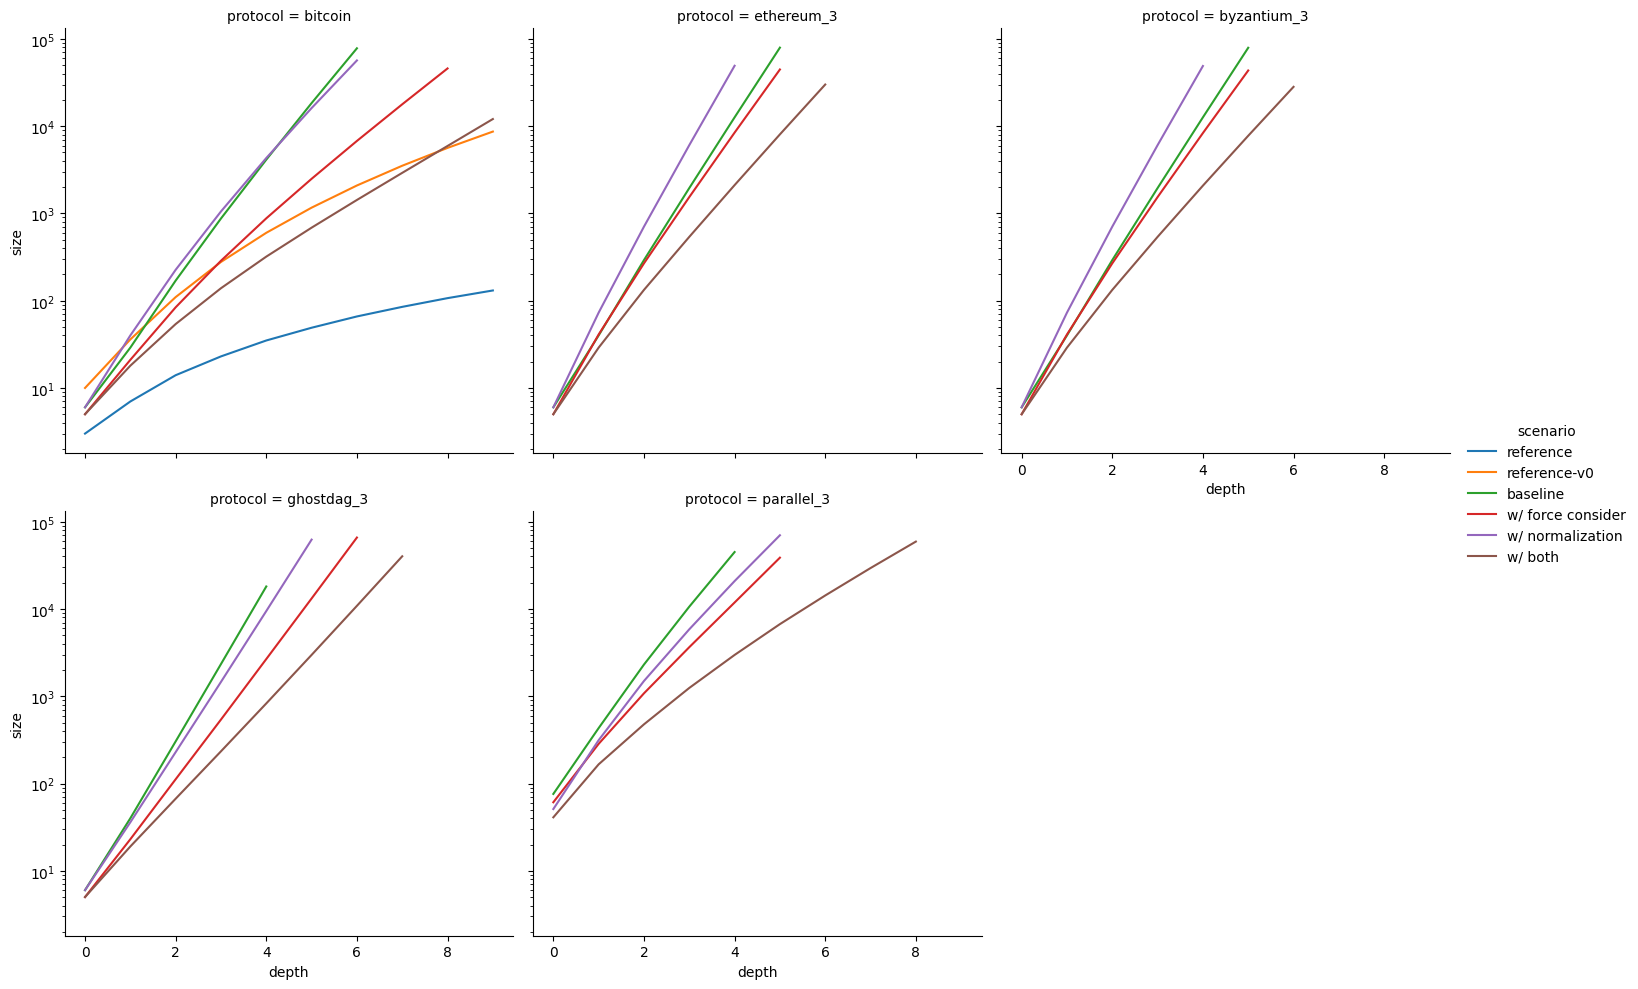

In [5]:
import seaborn

seaborn.relplot(
    data=size_log.query("depth < 10"),
    kind="line",
    x="depth",
    y="size",
    hue="scenario",
    col="protocol",
    col_wrap=3,
).set(yscale="log")

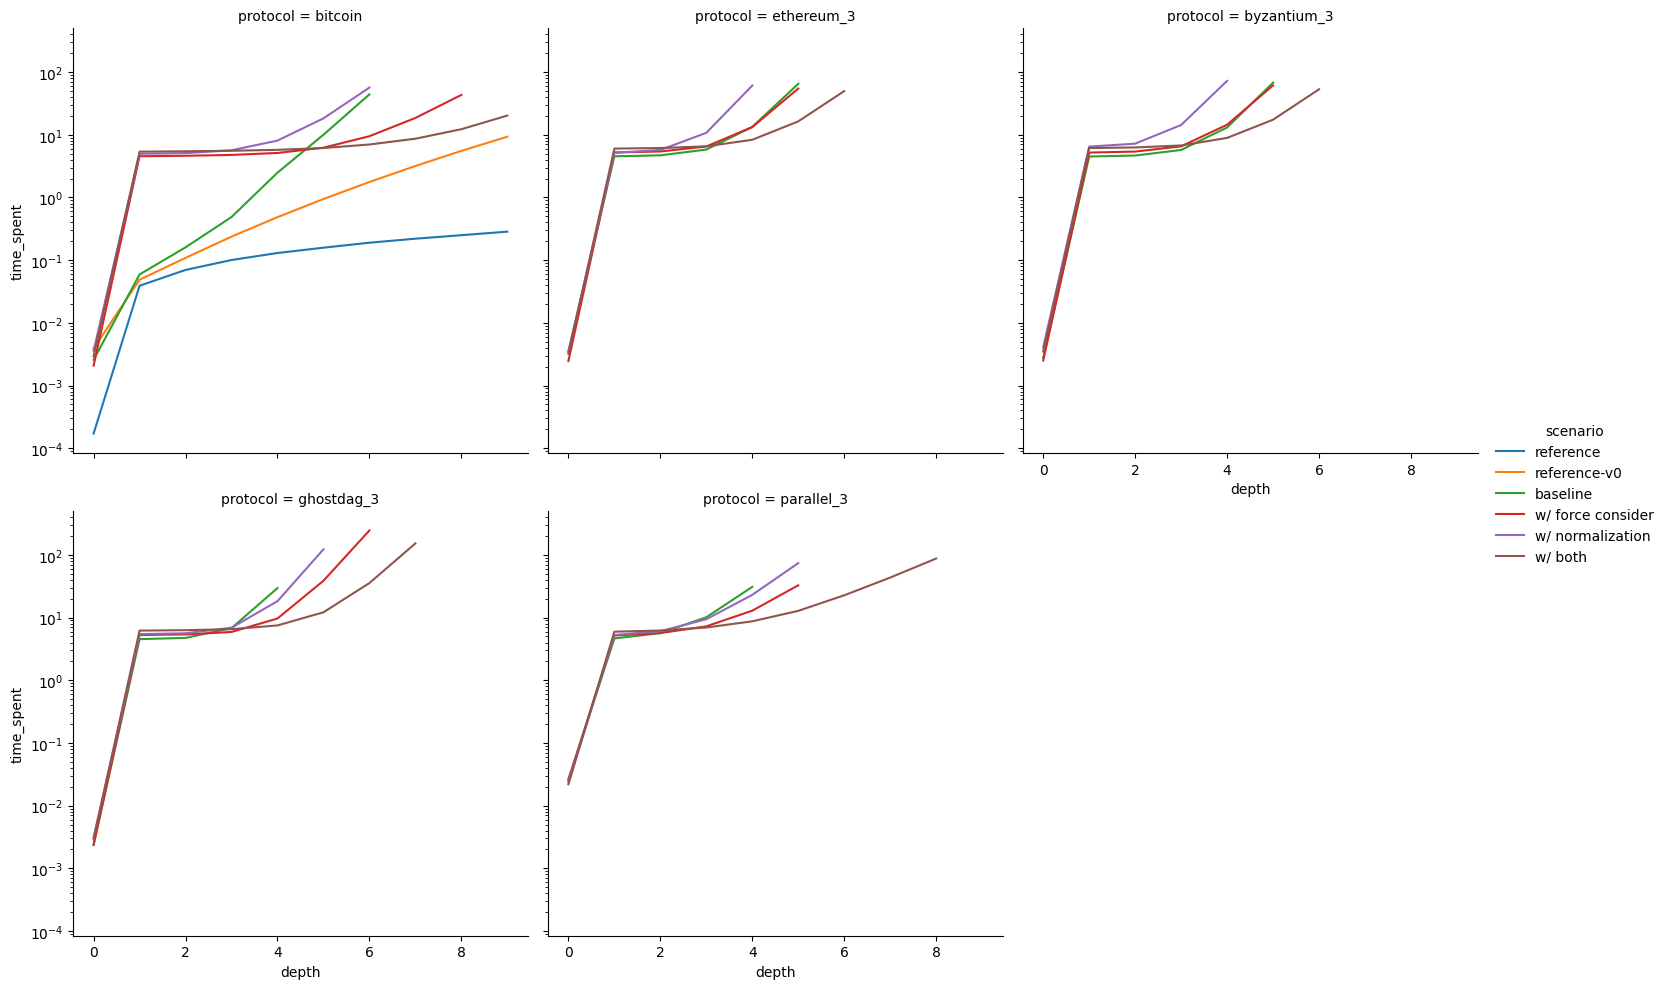

In [6]:
seaborn.relplot(
    data=size_log.query("depth < 10"),
    kind="line",
    x="depth",
    y="time_spent",
    hue="scenario",
    col="protocol",
    col_wrap=3,
).set(yscale="log")

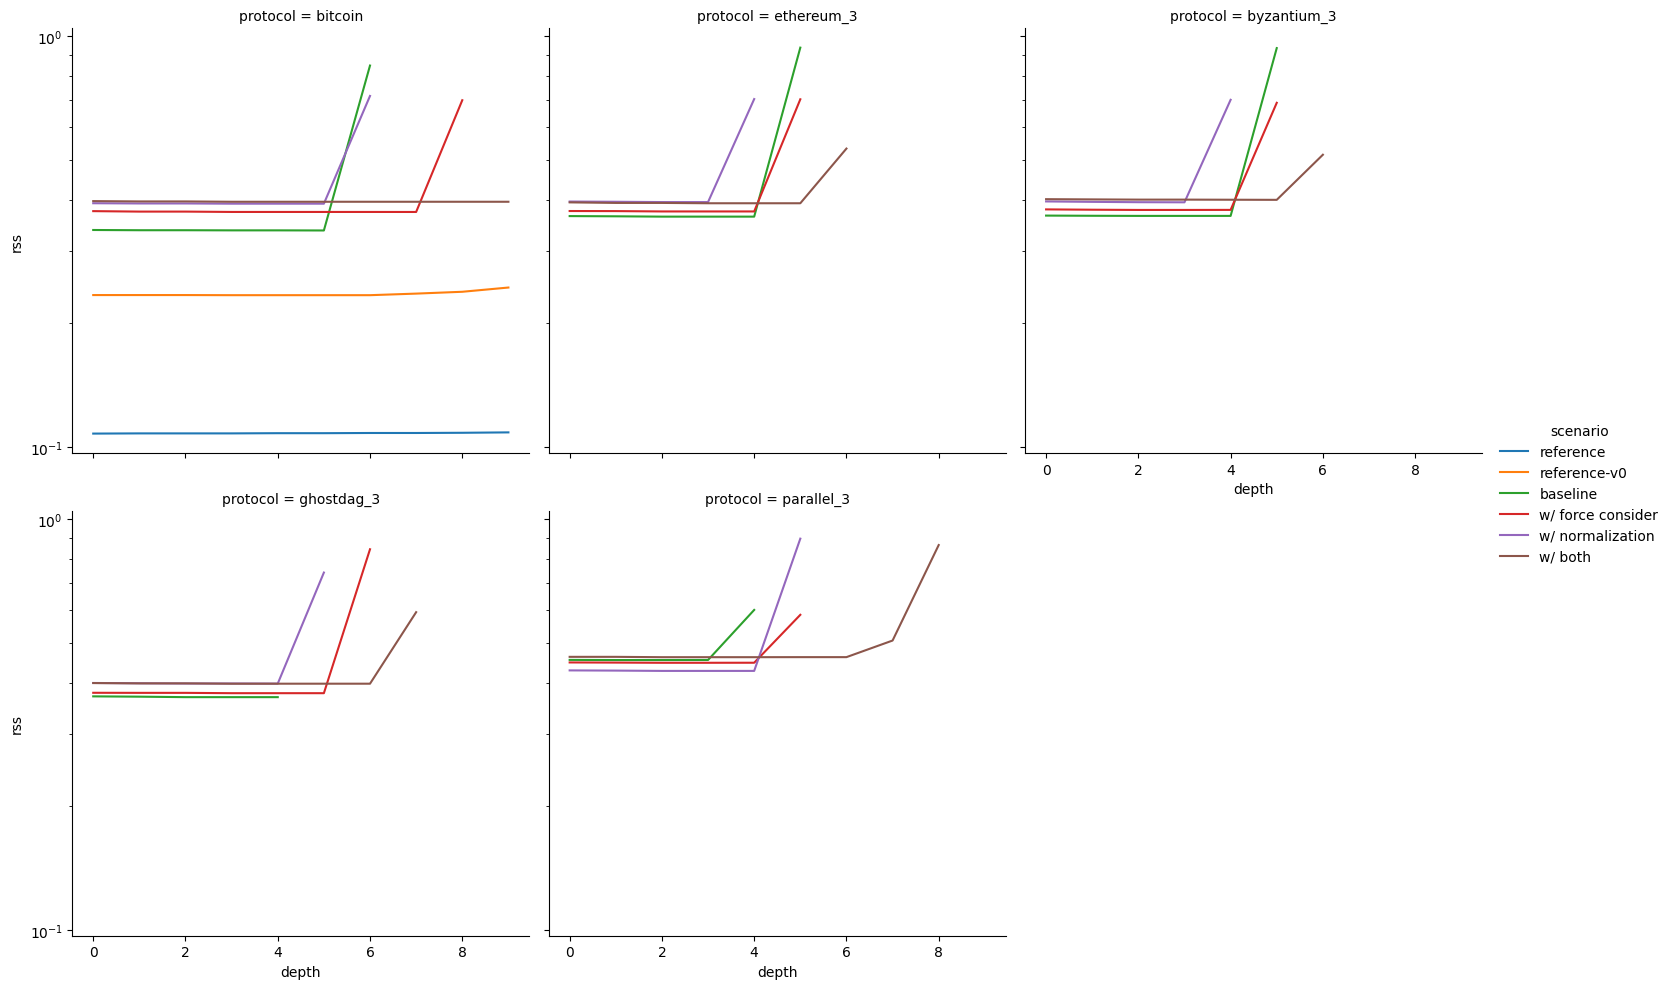

In [7]:
seaborn.relplot(
    data=size_log.query("depth < 10"),
    kind="line",
    x="depth",
    y="rss",
    hue="scenario",
    col="protocol",
    col_wrap=3,
).set(yscale="log")

In [8]:
sum(aborts.time_spent) / 60  # minutes

61.87719633091668